In [2]:
#  Given certain features, such as the number of rallies in a point and the speed of the last shot, 
# could we build a model that accurately predicts the outcome of a point in tennis? 
# There are 3 possible outcomes: winner (W), unforced error (UE), or forced error (F).

#  Since the number of outcomes is discrete and finite, it is evident that this will be a classification problem. And, 
#  this will be a supervised learning problem, where we are given the inputs as well as the outputs.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
%matplotlib inline


In [3]:
# Columns in Data With Categorical Values- Must LabelEncode them
categorical_cols = ['hitpoint', 'outside_sideline', 
                    'outside_baseline', 'same_side', 
                    'previous_hitpoint', 
                    'server_is_impact_player', 
                    'gender']

# Columns in the Data That Should Be Scaled
scaled_data = ['serve', 'rally', 'speed', 'net.clearance', 
               'distance.from.sideline', 'depth', 
               'player.distance.travelled', 
               'player.impact.depth', 
               'player.impact.distance.from.center', 
               'player.depth', 
               'player.distance.from.center', 
               'previous.speed', 'previous.net.clearance', 
               'previous.distance.from.sideline', 
               'previous.depth', 'opponent.depth', 
               'opponent.distance.from.center', 
               'previous.time.to.net']


df_train = pd.read_csv('tennis_data/train-1542197608821.csv')
# train_data.head()
def load_tennis_data():
    df = pd.read_csv('tennis_data/train-1542197608821.csv')
    df.columns = [col.replace('.', '_') for col in df.columns]
    df = df.drop(['ID'], axis=1)
    return df

In [4]:
df_train = load_tennis_data()
df_train.head()
df_train['is_forced_error'] = df_train['outcome'] == 'FE'
df_train['is_unforced_error'] = df_train['outcome'] == 'UE'
df_train['is_winner'] = df_train['outcome'] == 'W'
df_train['outcome'] = (df_train['outcome'].astype('category')
    .cat.as_ordered()
    .cat.reorder_categories(['FE', 'W', 'UE'])
    .cat.rename_categories({'FE': 'Forced Error', 
                         'W': 'Winner',
                         'UE': 'Unforced Error'}))

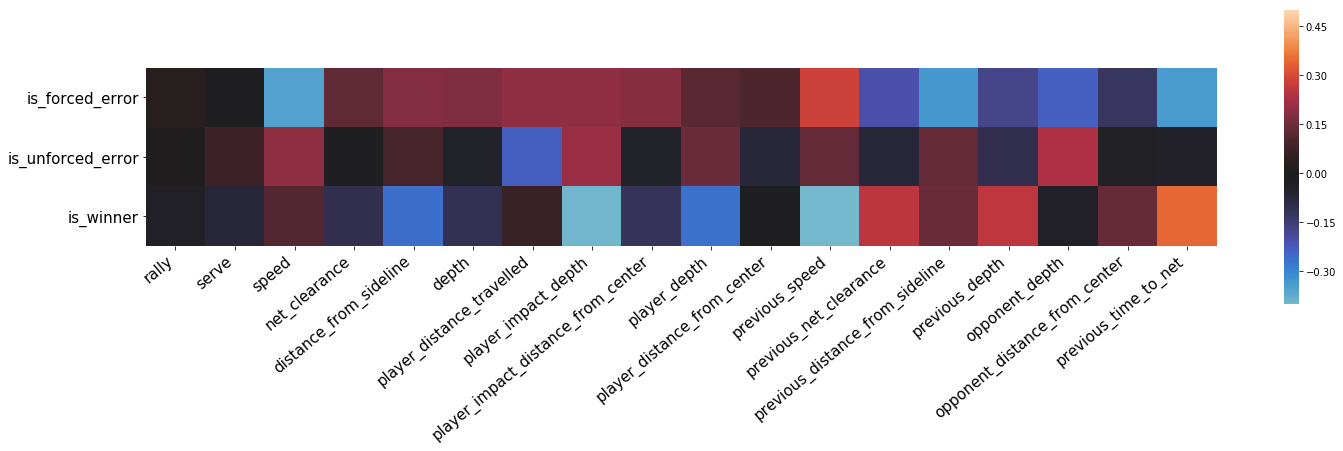

In [5]:
remove_vars = [ 'hitpoint', 
    'outside_sideline', 'outside_baseline', 
    'same_side', 'previous_hitpoint',
    'server_is_impact_player', 'gender']
response_vars = ['is_forced_error', 
    'is_unforced_error', 'is_winner']

plot_cols = df_train.drop(remove_vars, axis=1).columns.tolist()

corrmat = df_train[plot_cols].corr()
f, ax = plt.subplots(figsize=(24, 18))
heatmap = sns.heatmap(
    corrmat.loc[~corrmat.index.isin(response_vars),
                response_vars].T, 
    vmax=0.5, square=True, center = 0,
    cbar_kws={'shrink': 0.3})
heatmap.set_xticklabels(heatmap.get_xticklabels(),
                        rotation=40, fontsize=15, 
                        ha='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), 
                        rotation=0, fontsize=15)
plt.show()


In [5]:
# Is the point an expected winner?
## net.clearance (> 0)
## outside_sideline (False)
## outside_baseline (False)  

df_train['clears_net'] = df_train['net_clearance'] > 0
df_train['expected_winner'] = (df_train['clears_net'] & 
                               -df_train['outside_sideline'] & 
                               -df_train['outside_baseline'])

df_train['faulty_expected_winner'] = ((df_train['expected_winner'] == True) &
                                      (df_train['outcome'] != 'Winner'))

In [8]:
df_train_counts = df_train.groupby(
    ['expected_winner', 'outcome'])['rally'].count()

table = ((df_train_counts / df_train_counts.groupby(['expected_winner']) \
    .transform(sum))
 .reset_index()
 .rename(columns={'rally': '% of points', 
    'expected_winner': 'expected winner'}))
table['% of points'] = table['% of points'].map(lambda x: '{:,.1%}'.format(x))
HTML(table.to_html(index=False))

expected winner,outcome,% of points
False,Forced Error,32.9%
False,Winner,1.5%
False,Unforced Error,65.7%
True,Forced Error,5.9%
True,Winner,86.5%
True,Unforced Error,7.6%


While only 1.5% of expected errors are called winners, 13.5% of "expected winners" are not actually winners.

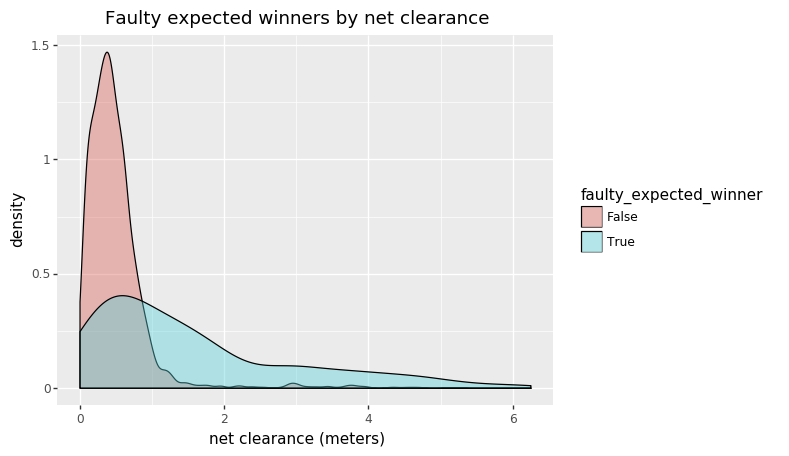

In [8]:
import plotnine as p9
df_expected_winner = df_train[df_train['expected_winner'] == True]

gg = (p9.ggplot(
    df_expected_winner[df_expected_winner['net_clearance'] < 7], 
    p9.aes(x = 'net_clearance', fill = 'faulty_expected_winner')) +
    p9.geom_density(alpha = 0.4) +
    p9.scale_x_continuous() +
    p9.labs(x = 'net clearance (meters)',
        y = 'density',
        title = 'Faulty expected winners by net clearance'))
gg.draw(); plt.show()

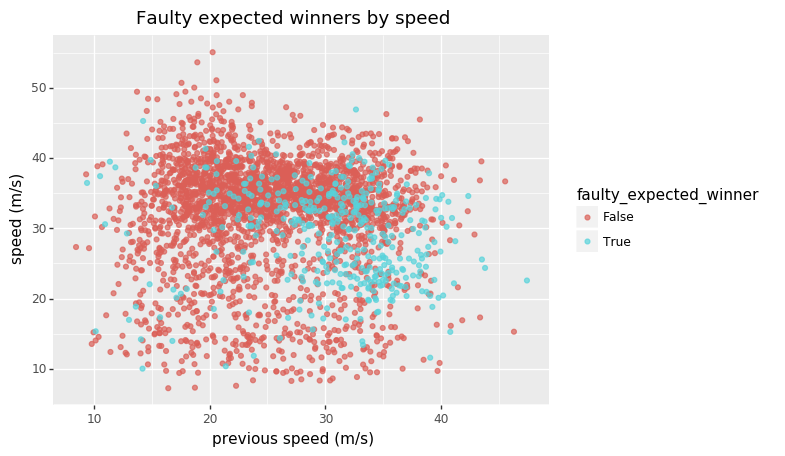

In [9]:
gg = (p9.ggplot(df_expected_winner, 
    p9.aes(x = 'previous_speed', y = 'speed', 
           color = 'faulty_expected_winner')) +
    p9.geom_point(alpha = 0.7) +
    p9.labs(x = 'previous speed (m/s)', 
        y = 'speed (m/s)',
        title = 'Faulty expected winners by speed'))
gg.draw(); plt.show()

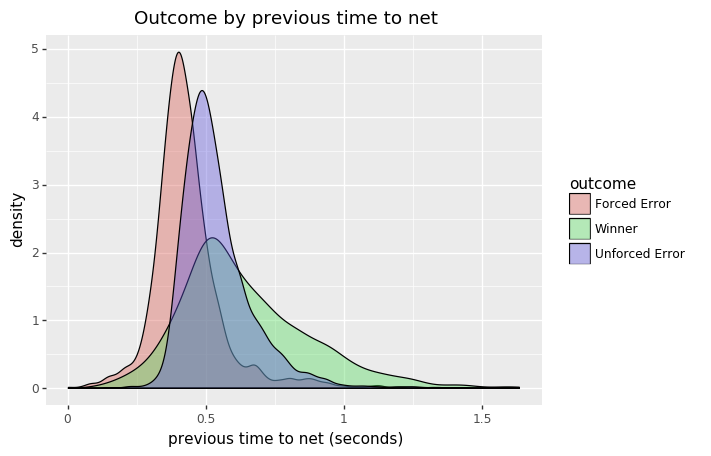

In [10]:
gg = (p9.ggplot(df_train, 
    p9.aes(x = 'previous_time_to_net', fill = 'outcome')) +
    p9.geom_density(alpha = 0.4) +
    p9.labs(x = 'previous time to net (seconds)',
        y = 'density',
        title = 'Outcome by previous time to net'))
gg.draw(); plt.show()

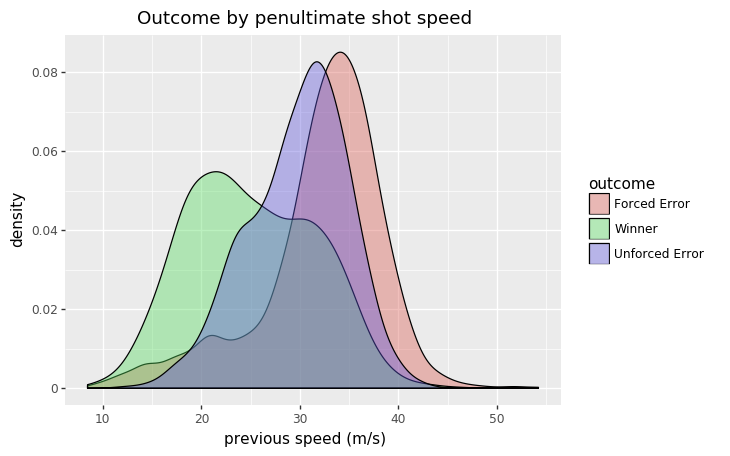

In [11]:
gg = (p9.ggplot(df_train, 
    p9.aes(x = 'previous_speed', fill = 'outcome')) +
    p9.geom_density(alpha = 0.4) +
    p9.labs(x = 'previous speed (m/s)', 
        y = 'density',
        title = 'Outcome by penultimate shot speed'))
gg.draw(); plt.show()

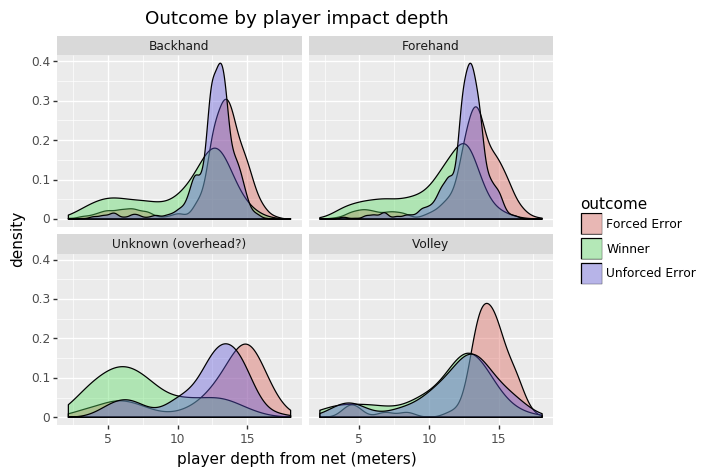

In [12]:
df_train['shot_type'] = (
    np.where(df_train['hitpoint'] == 'B', 'Backhand', 
    np.where(df_train['hitpoint'] == 'F', 'Forehand',
    np.where(df_train['hitpoint'] == 'V', 'Volley', 
    'Unknown (overhead?)'))))

gg = (p9.ggplot(df_train,
    p9.aes(x = 'player_impact_depth', fill = 'outcome')) +
    p9.geom_density(alpha = 0.4) +
    p9.facet_wrap('~shot_type') +
    p9.labs(x = 'player depth from net (meters)', 
        y = 'density',
        title = 'Outcome by player impact depth'))
gg.draw(); plt.show()

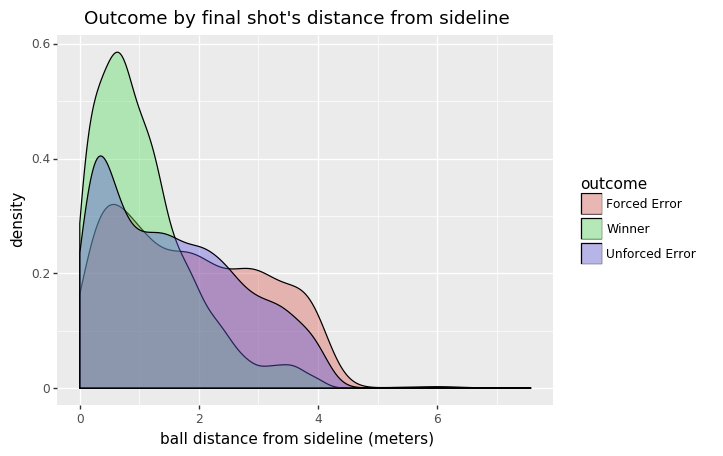

In [13]:
gg = (p9.ggplot(df_train, 
    p9.aes(x = 'distance_from_sideline', fill = 'outcome')) +
    p9.geom_density(alpha = 0.4) +
    p9.labs(x = 'ball distance from sideline (meters)',
        y = 'density',
        title = 'Outcome by final shot\'s distance from sideline'))
gg.draw(); plt.show()